In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [233]:
def remove_punct(df):
    """
    Removes semantically meaningless punctuation (components use : to denote hierarchy)
    Parameters:
        df (dataframe): dataframe containing text for cleaning
    Returns:
        dataframe
    """
    cols = df.columns
    for col in cols:
        try:
            if df[col].dtype == "O" and col != "COMPNAME" and col != "COMPDESC":
                df.loc[:, col] = df[col].str.replace(r"[^\w\s-]", "", regex=True)
        except AttributeError as e:
            print(f"Check for non-string datatypes in {col}: {e}")


def lowercase(df):
    """
    Converts text to lowercase.
    Parameters:
        df (dataframe): dataframe containing text for cleaning
    Returns:
        dataframe
    """
    cols = df.columns
    for col in cols:
        try:
            if df[col].dtype == "O":
                df.loc[:, col] = df[col].str.lower()
        except AttributeError as e:
            print(f"Check for non-string datatypes: {e}")


def convert_datetime(data, columns=None, format="%Y%m%d", errors="coerce"):
    """
    Converts given columns to datetime.
    Parameters:
        data (pandas.DataFrame): The DataFrame containing the data to be converted.
        columns (list | None): The list of column names to be converted to datetime (default is ["RCDATE", "DATEA"]).
        format (str, optional): The format string used to parse the datetime columns (default is "%Y%m%d").
        errors (str, optional): How to handle parsing errors. Options are "raise", "coerce",
          and "ignore" (default is "coerce", which converts parsing errors to NaT).

    Returns:
        None: The function modifies the input DataFrame in place
    """
    if columns is None:
        columns = ["RCDATE", "DATEA", "ODATE", "BGMAN", "ENDMAN"]
    for col in columns:
        data.loc[:, col] = pd.to_datetime(data[col], format=format, errors=errors)

# When the Customer Is Right: Analyzing Automotive Customer Complaint Data to Identify Serious Safety Issues

## Step 1
### Identify Components Most Implicated in Recalls

In [234]:
# Load recall data
recalls_headers = pd.read_csv("./data/RCL_headers.txt")
recalls_head = recalls_headers.values.tolist()
rcl_headers = [head for sublist in recalls_head for head in sublist]

recalls = pd.read_csv(
    "./data/FLAT_RCL.txt", sep="\t", names=rcl_headers, on_bad_lines="warn"
)

Skipping line 188394: expected 27 fields, saw 34

/var/folders/4x/y38ttwq12519_qtj737r25vh0000gn/T/ipykernel_70520/2183926908.py:6: DtypeWarning: Columns (17,18,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  recalls = pd.read_csv(


In [235]:
# Examine mixed dtypes for potential problems
recalls.iloc[:, [17,18,24,25,26]].sample(10)


,RPNO,FMVSS,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO
228530,NaN,NaN,SW communication module,SW communication module,A2479023512
235923,NaN,NaN,Fuel Delivery Unit,Fuel Delivery Unit,A1674706900
6710,NaN,NaN,NaN,NaN,NaN
31794,571.0,109.0,NaN,NaN,NaN
221011,NaN,NaN,SW communication module,SW communication module,A2229027718
9739,NaN,NaN,NaN,NaN,NaN
246366,NaN,NaN,Windshield Wiper,"Windshield Wiper, Assembly LHD Reduced",84724203
245331,NaN,NaN,NaN,NaN,NaN
223659,NaN,NaN,SW communication module,SW communication module,A2229029220
148243,NaN,NaN,NaN,NaN,NaN


In [236]:
recalls.sample(2)

,RECORD_ID,CAMPNO,MAKETXT,MODELTXT,YEARTXT,MFGCAMPNO,COMPNAME,MFGNAME,BGMAN,ENDMAN,...,RPNO,FMVSS,DESC_DEFECT,CONEQUENCE_DEFECT,CORRECTIVE_ACTION,NOTES,RCL_CMPT_ID,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO
215539,215543,22V255000,FORD,EXPLORER INTERCEPT HYBRID,2020,22S27,POWER TRAIN:AXLE ASSEMBLY,Ford Motor Company,NaN,NaN,...,NaN,NaN,Ford Motor Company (Ford) is recalling certain...,A disconnected driveshaft can result in vehicl...,"Depending on the vehicle model, dealers will r...",Owners may also contact the National Highway T...,000119717005291752000000195,Axle Cover,Axle Cover,L1MW-4A028-G
225658,225662,22V365000,MERCEDES-BENZ,E450,2020,2022060005,COMMUNICATION: AUTO CRASH NOTIFICATION,"Mercedes-Benz USA, LLC",NaN,NaN,...,NaN,NaN,"Mercedes-Benz USA, LLC (MBUSA) is recalling ce...",A disabled eCall system would prevent a vehicl...,The communication module software will be upda...,Owners may also contact the National Highway T...,000120389004286718000001420,SW communication module,SW communication module,A2229023217


In [237]:
recalls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248841 entries, 0 to 248840
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   RECORD_ID          248841 non-null  int64  
 1   CAMPNO             248841 non-null  object 
 2   MAKETXT            248841 non-null  object 
 3   MODELTXT           248841 non-null  object 
 4   YEARTXT            248841 non-null  int64  
 5   MFGCAMPNO          150692 non-null  object 
 6   COMPNAME           248841 non-null  object 
 7   MFGNAME            248836 non-null  object 
 8   BGMAN              115289 non-null  float64
 9   ENDMAN             115533 non-null  float64
 10  RCLTYPECD          248841 non-null  object 
 11  POTAFF             248555 non-null  float64
 12  ODATE              236645 non-null  float64
 13  INFLUENCED_BY      248841 non-null  object 
 14  MFGTXT             248841 non-null  object 
 15  RCDATE             248841 non-null  int64  
 16  DA

In [238]:
# Basic data cleaning
lowercase(recalls)
remove_punct(recalls)
convert_datetime(recalls)
convert_datetime(recalls, columns=["YEARTXT"], format="%Y")
recalls.sample(10)

,RECORD_ID,CAMPNO,MAKETXT,MODELTXT,YEARTXT,MFGCAMPNO,COMPNAME,MFGNAME,BGMAN,ENDMAN,...,RPNO,FMVSS,DESC_DEFECT,CONEQUENCE_DEFECT,CORRECTIVE_ACTION,NOTES,RCL_CMPT_ID,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO
17274,17275,95v087000,thomas,conventional,1994-01-01,NaN,"visibility:glass, side/rear",thomas built buses inc,1994-09-01,1995-04-01,...,NaN,NaN,the roof hatches on these buses do not meet th...,consequence of non-compliance in the event of...,dealers will remove the existing roof hatch li...,system visual glass other fmvss no 217vehicle ...,000007361000016020000000237,NaN,NaN,NaN
96063,96064,13v014000,toyota,tacoma,2009-01-01,NaN,air bags:frontal:sensor/control module-inactive,southeast toyota distributors llc,NaT,NaT,...,NaN,NaN,southeast toyota distributors llc set is recal...,if the front passenger seat occupant sensing s...,southeast toyota will notify owners and dealer...,owners may also contact the national highway t...,000052593000452763000000258,NaN,NaN,NaN
102575,102576,14v234000,chrysler,town and country,2013-01-01,p25,electrical system,chrysler group llc,2010-08-25,2013-10-31,...,NaN,NaN,chrysler group llc chrysler is recalling certa...,an overheated switch may result in a vehicle fire,chrysler will notify owners and dealers will r...,owners may also contact the national highway t...,000056414001689819000000200,NaN,NaN,NaN
225283,225287,22v365000,mercedes-benz,glc350,2019-01-01,2022060005,communication: auto crash notification,mercedes-benz usa llc,NaT,NaT,...,NaN,NaN,mercedes-benz usa llc mbusa is recalling certa...,a disabled ecall system would prevent a vehicl...,the communication module software will be upda...,owners may also contact the national highway t...,000120389004706751000001420,sw communication module,sw communication module,a2239022725
9923,9924,99v043000,dodge,neon,2000-01-01,821,air bags:frontal,daimlerchrysler corporation,1998-11-15,1999-01-15,...,NaN,NaN,vehicle description passenger vehicles some...,in the event of a crash the passenger may not ...,dealers will replace the air bag module on the...,owner notification began april 5 1999owners wh...,000009025000203498000000257,NaN,NaN,NaN
58265,58266,72v063000,gmc,tv7500,1968-01-01,NaN,power train:manual transmission:shift pattern ...,general motors corp,1971-08-01,1971-09-01,...,NaN,NaN,NaN,NaN,NaN,possibility that shift pattern arrangement dec...,000001016000048171000000178,NaN,NaN,NaN
118976,118977,16v390000,pierce,velocity,2015-01-01,74b272,equipment,pierce manufacturing,2015-08-04,2016-04-24,...,NaN,NaN,pierce manufacturing pierce is recalling certa...,if the strainer andor debris enters the pump a...,pierce will notify owners to check the straine...,owners may also contact the national highway t...,000059014001986784000000329,NaN,NaN,NaN
217369,217373,22v365000,mercedes-maybach,s650,2019-01-01,2022060005,electrical system:software,mercedes-benz usa llc,NaT,NaT,...,NaN,NaN,mercedes-benz usa llc mbusa is recalling certa...,a disabled ecall system would prevent a vehicl...,the communication module software will be upda...,owners may also contact the national highway t...,000120389003816722000001105,sw communication module,sw communication module,a1779021200
108267,108268,14v742000,champion,cts-fe,2013-01-01,NaN,equipment adaptive/mobility,champion bus inc,2006-01-01,2014-07-31,...,NaN,NaN,champion bus inc champion bus is recalling cer...,if the platform side plates crack the lift pla...,champion bus will notify owners to take buses ...,owners may also contact the national highway t...,000057100001979459000001004,NaN,NaN,NaN
14566,14567,96v055003,american international,chevrolet c10,1996-01-01,NaN,seats,american intl conversions,1994-07-01,1996-02-01,...,NaN,NaN,vehicle description light duty extended cab c...,if this were to occur to the drivers seat this...,vss is conducting the notification and remedy ...,system interior seat track anchors and seat ve...,000007868000087582000000318,NaN,NaN,NaN


In [239]:
recalls["ODATE"]

0        2003-02-10
1        2003-02-10
2        2002-09-23
3        2002-11-05
4        2002-11-05
            ...    
248836   2023-09-20
248837   2023-09-20
248838   2023-08-16
248839   2023-08-16
248840   2023-08-16
Name: ODATE, Length: 248841, dtype: datetime64[ns]

#### Recalls EDA

In [270]:
# Number of recall campaigns
print(f"Recall campaigns count: {len(recalls['CAMPNO'].unique())}")

# Number of unique components recalled
print(f"Number of unique components recalled: {len(recalls['RCL_CMPT_ID'].unique())}")

# Timeframe of Complaints
print(f"Earliest recall report: {min(recalls['RCDATE'])}\n Most recent recall report: {max(recalls['RCDATE'])}")

Recall campaigns count: 27436
Number of unique components recalled: 176081
Earliest recall report: 1966-01-19 00:00:00
 Most recent recall report: 2023-11-10 00:00:00


In [241]:
# Check for variations in manufacturer name for companies of interest
# GM, Toyota, Tesla, Ford, Hyundai, Honda
gm = recalls.query('MFGNAME.str.contains("general motors", case=False, na=False)')
gm.loc[gm["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['general motors corp', 'general motors llc']

In [242]:
toyota = recalls.query('MFGNAME.str.contains("toyota", case=False, na=False)')
toyota.loc[toyota["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['toyota motor north america inc',
 'southeast toyota distributors',
 'gulf states toyota inc',
 'toyota motor co ltd',
 'toyota motor engineering  manufacturing',
 'southeast toyota distributors llc']

In [243]:
tesla = recalls.query('MFGNAME.str.contains("tesla", case=False, na=False)')
tesla.loc[tesla["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['tesla motors inc', 'tesla motors', 'tesla inc']

In [244]:
ford = recalls.query('MFGNAME.str.contains("ford", case=False, na=False)')
ford.loc[ford["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['ford motor company',
 'ford mtr co-overseas',
 'zf lemforder corporation',
 'ford motor company test adw as',
 'c  c ford']

In [245]:
hyundai = recalls.query('MFGNAME.str.contains("hyundai", case=False, na=False)')
hyundai.loc[hyundai["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['hyundai motor company',
 'hyundai caribbean-puerto rico',
 'hyundai translead',
 'hyundai motor america',
 'hyundai truck america']

In [246]:
honda = recalls.query('MFGNAME.str.contains("honda", case=False, na=False)')
honda.loc[honda["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['american honda motor co', 'honda american honda motor co', 'honda of minola']

In [247]:
# Standardize manufacturer names
recalls["MFGNAME"].replace(
    {
        "general motors llc": "general motors corp",
        "tesla motors inc": "tesla inc",
        "tesla motors": "tesla inc",
        "honda american honda motor co": "american honda motor co",
    },
    inplace=True,
)

In [248]:
# Check standardization
honda = recalls.query('MFGNAME.str.contains("honda", case=False, na=False)')
honda.loc[honda["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['american honda motor co', 'honda of minola']

In [249]:
recalls_mfr_count = pd.DataFrame(recalls["MFGNAME"].value_counts(ascending=False))

print(
    f"Top 20 manufacturers most represented in recall data:\n{recalls_mfr_count[:20]}"
)

Top 20 manufacturers most represented in recall data:
                                         count
MFGNAME                                       
mercedes-benz usa llc                    41784
ford motor company                       12779
general motors corp                      10062
american honda motor co                   7044
daimler trucks north america llc          6932
paccar incorporated                       4920
forest river inc                          4637
nissan north america inc                  3593
bmw of north america llc                  3550
toyota motor engineering  manufacturing   3181
volkswagen group of america inc           3156
jaguar land rover north america llc       3015
chrysler corporation                      2804
chrysler fca us llc                       2670
blue bird body company                    2619
winnebago industries inc                  2306
navistar inc                              2276
prevost car us inc                        2270
daimle

In [250]:
recalls_mfr_count["percentage_of_recalls"] = recalls_mfr_count["count"] / len(recalls)
recalls_mfr_count.sort_values(by="percentage_of_recalls", ascending=False)[:20]

,count,percentage_of_recalls
MFGNAME,,
mercedes-benz usa llc,41784,0.167914
ford motor company,12779,0.051354
general motors corp,10062,0.040435
american honda motor co,7044,0.028307
daimler trucks north america llc,6932,0.027857
paccar incorporated,4920,0.019772
forest river inc,4637,0.018634
nissan north america inc,3593,0.014439
bmw of north america llc,3550,0.014266


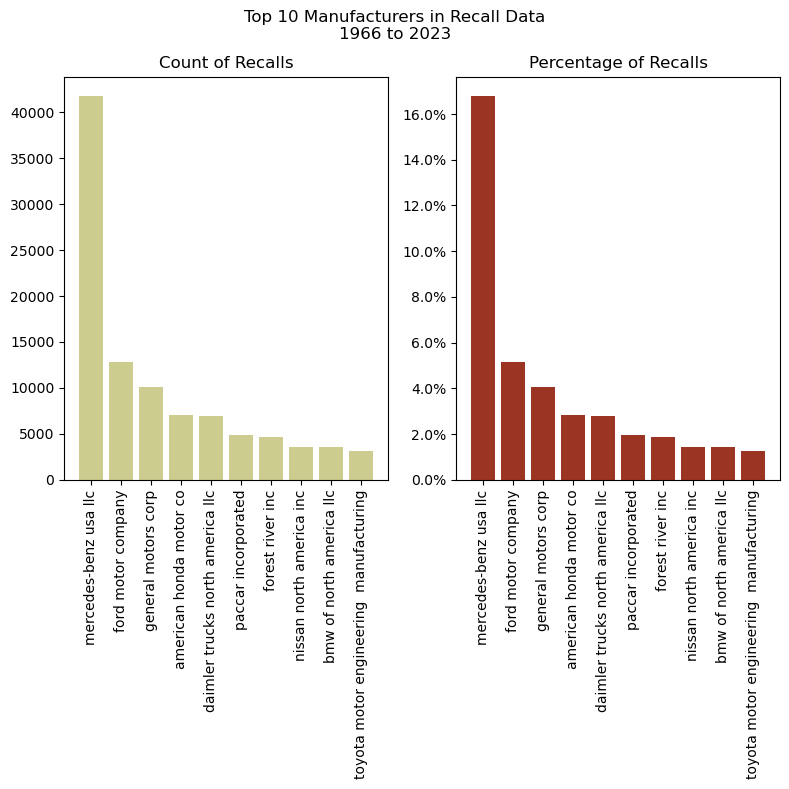

In [251]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
ax1.bar(
    recalls_mfr_count.reset_index()["MFGNAME"][:10],
    recalls_mfr_count["count"][:10],
    color="#cbcc8d",
)
ax1.set_xticks(recalls_mfr_count.reset_index()["MFGNAME"][:10])
ax1.set_xticklabels(recalls_mfr_count.reset_index()["MFGNAME"][:10], rotation=90)
ax1.set_title("Count of Recalls")

ax2.bar(
    recalls_mfr_count.reset_index()["MFGNAME"][:10],
    recalls_mfr_count["percentage_of_recalls"][:10],
    color="#9c3424",
)
ax2.set_xticks(recalls_mfr_count.reset_index()["MFGNAME"][:10])
ax2.set_xticklabels(recalls_mfr_count.reset_index()["MFGNAME"][:10], rotation=90)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.set_title("Percentage of Recalls")
plt.suptitle("Top 10 Manufacturers in Recall Data\n1966 to 2023")
plt.tight_layout()

In [252]:
# Get list of recall-prone components
rcl_common_compnames = pd.DataFrame(
    recalls["COMPNAME"].value_counts(ascending=False)[:50]
).reset_index()
rcl_common_compnames.to_csv("./output/allrcl_common_comps.csv")
rcl_common_compnames

,COMPNAME,count
0,electrical system:software,18922
1,communication: auto crash notification,16630
2,equipment,11825
3,equipment:recreational vehicle/trailer,8015
4,equipment adaptive/mobility,5201
5,exterior lighting,4945
6,equipment:other:labels,4927
7,air bags:frontal:passenger side:inflator module,4440
8,electrical system,4364
9,"fuel system, gasoline:delivery:fuel pump",4111


#### Filter for Manufacturers of Interest

In [253]:
select_mfrs = [
    "general motors corp",
    "tesla inc",
    "toyota motor north america inc",
    "ford motor company",
    "american honda motor co",
    "hyundai motor america",
]
recalls_filtered = recalls[recalls["MFGNAME"].isin(select_mfrs)]
recalls_filtered["MFGNAME"].value_counts()

MFGNAME
ford motor company                12779
general motors corp               10062
american honda motor co            7044
hyundai motor america               952
tesla inc                           607
toyota motor north america inc      477
Name: count, dtype: int64

#### Split Components

In [254]:
parts = recalls_filtered["COMPNAME"].str.split(":", expand=True)
parts.columns = [f"COMPSYS_{i + 1}" for i in range(len(parts.columns))]
parts

,COMPSYS_1,COMPSYS_2,COMPSYS_3,COMPSYS_4,COMPSYS_5
0,electrical system,12v/24v/48v battery,cables,None,None
1,electrical system,12v/24v/48v battery,cables,None,None
48,wheels,None,None,None,None
49,wheels,None,None,None,None
148,"fuel system, other",storage,tank assembly,None,None
...,...,...,...,...,...
248696,electrical system,None,None,None,None
248697,electrical system,None,None,None,None
248698,electrical system,None,None,None,None
248723,power train,driveline,driveshaft,None,None


In [255]:
rcls_filter_enrich = pd.concat([recalls_filtered, parts], axis=1)
rcls_filter_enrich.head()

,RECORD_ID,CAMPNO,MAKETXT,MODELTXT,YEARTXT,MFGCAMPNO,COMPNAME,MFGNAME,BGMAN,ENDMAN,...,NOTES,RCL_CMPT_ID,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO,COMPSYS_1,COMPSYS_2,COMPSYS_3,COMPSYS_4,COMPSYS_5
0,1,02v288000,ford,focus,2000-01-01,02s41,electrical system:12v/24v/48v battery:cables,ford motor company,1999-07-19,2001-05-31,...,also contact the national highway traffic safe...,000015339000215021000000202,NaN,NaN,NaN,electrical system,12v/24v/48v battery,cables,None,None
1,2,02v288000,ford,focus,2001-01-01,02s41,electrical system:12v/24v/48v battery:cables,ford motor company,1999-07-19,2001-05-31,...,also contact the national highway traffic safe...,000015339000215022000000202,NaN,NaN,NaN,electrical system,12v/24v/48v battery,cables,None,None
48,49,02v250000,honda,silver wing,2002-01-01,NaN,wheels,american honda motor co,2001-08-08,2002-07-08,...,also customers can contact the national highwa...,000015234000106389000000309,NaN,NaN,NaN,wheels,None,None,None,None
49,50,02v250000,honda,fsc600,2002-01-01,NaN,wheels,american honda motor co,2001-08-08,2002-07-08,...,also customers can contact the national highwa...,000015234000106390000000309,NaN,NaN,NaN,wheels,None,None,None,None
148,149,02v249000,ford,crown victoria,2002-01-01,02s39,"fuel system, other:storage:tank assembly",ford motor company,2001-05-10,2002-03-22,...,also contact the national highway traffic safe...,000015251000215009000000162,NaN,NaN,NaN,"fuel system, other",storage,tank assembly,None,None


## Step 2
### Load and Clean Complaints Data

In [256]:
complt_headers = pd.read_csv("./data/CMPL_headers.txt")
complt_head = complt_headers.values.tolist()
cmpl_headers = [head for sublist in complt_head for head in sublist]

cmplt = pd.read_csv("./data/FLAT_CMPL.txt", sep="\t", names=cmpl_headers, on_bad_lines="warn")

Skipping line 555891: expected 49 fields, saw 70

/var/folders/4x/y38ttwq12519_qtj737r25vh0000gn/T/ipykernel_70520/4001186840.py:5: DtypeWarning: Columns (15,16,18,27,28,29,30,32,33,34,35,38,39,40,41,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  cmplt = pd.read_csv("./data/FLAT_CMPL.txt", sep="\t", names=cmpl_headers, on_bad_lines="warn")


In [265]:
# NOTE: CMPLID appears to just be the row number (index)
cmplt.head(2)

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,LOC_OF_TIRE,TIRE_FAIL_TYPE,ORIG_EQUIP_YN,MANUF_DT,SEAT_TYPE,RESTRAINT_TYPE,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
1,958241,volvo car usa llc,volvo,760,1987-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
2,958130,ford motor company,ford,thunderbird,1992-01-01,n,1994-12-22,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n


In [257]:
# Examine mixed dtypes for potential problems
print(cmplt.iloc[:, [15,16,18,27,28,29,30,32,33,34,35,38,39,40,41,42,43,44]].dtypes)

cmplt.iloc[:, [15,16,18,27,28,29,30,32,33,34,35,38,39,40,41,42,43,44]].sample(5)

LDATE              object
MILES             float64
CDESCR             object
FUEL_SYS           object
FUEL_TYPE          object
TRANS_TYPE         object
VEH_SPEED         float64
TIRE_SIZE          object
LOC_OF_TIRE        object
TIRE_FAIL_TYPE     object
ORIG_EQUIP_YN      object
RESTRAINT_TYPE     object
DEALER_NAME        object
DEALER_TEL         object
DEALER_CITY        object
DEALER_STATE       object
DEALER_ZIP         object
PROD_TYPE          object
dtype: object


,LDATE,MILES,CDESCR,FUEL_SYS,FUEL_TYPE,TRANS_TYPE,VEH_SPEED,TIRE_SIZE,LOC_OF_TIRE,TIRE_FAIL_TYPE,ORIG_EQUIP_YN,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE
672274,20080603,NaN,RETURNED TO DEALER 4 TIMES FOR: BRAKES GOING ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CARL BLACK CHEVROLET,NaN,KENNESAW,00,NaN,V
805146,20100809,39000.0,TL*THE CONTACT OWNS A 2004 BMW Z4. WHILE THE C...,NaN,NaN,NaN,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V
1752959,20210621,100000.0,The contact's wife owns a 2012 Hyundai Veracru...,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,Imperial Hyundai,(508) 488-,MIlford,MA,01757,V
15685,19950703,NaN,"DRIVER'S SIDE SEAT BELT FAILURE, THE BUCKLE LA...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V
1758277,20210720,NaN,Approximately the end of June the airbag light...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V


In [258]:
# NOTE: Must execute before lowercasing and punctuation removal or conversion produces all NaN values
convert_datetime(cmplt, columns=["FAILDATE", "DATEA", "LDATE", "PURCH_DT", "MANUF_DT"])
convert_datetime(cmplt, columns=["YEARTXT"], format="%Y")

In [259]:
cmplt["FAILDATE"]

1                NaT
2         1994-12-22
3         1994-12-30
4         1994-12-31
5         1994-12-18
             ...    
1944091   2023-11-20
1944092   2022-04-22
1944093   2022-04-22
1944094   2023-11-23
1944095   2023-01-01
Name: FAILDATE, Length: 1943098, dtype: datetime64[ns]

In [260]:
# Basic data cleaning
convert_datetime(cmplt, columns=["YEARTXT"], format="%Y")
lowercase(cmplt)
remove_punct(cmplt)
cmplt.sample(10)

Check for non-string datatypes: Can only use .str accessor with string values!
Check for non-string datatypes: Can only use .str accessor with string values!
Check for non-string datatypes: Can only use .str accessor with string values!
Check for non-string datatypes: Can only use .str accessor with string values!


,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
1551101,11191032,chrysler fca us llc,jeep,patriot,2014-01-01,n,2019-03-22,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
341565,760093,general motors llc,gmc,vandura,1995-01-01,n,2002-03-29,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
1031332,10559216,hyundai motor america,hyundai,xg350,2004-01-01,n,2013-12-23,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
486232,10082464,general motors llc,oldsmobile,alero,2001-01-01,n,2004-07-21,n,0,0,...,NaN,south east auto sales,NaN,corbin,ky,40744,v,NaN,n,n
1912722,11534704,kia america inc,kia,ev6,2022-01-01,n,2023-06-01,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
1434148,11055694,hyundai motor america,hyundai,sonata,2012-01-01,n,2017-12-02,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
682867,10237961,honda american honda motor co,honda,odyssey,2003-01-01,n,2008-08-11,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
1369122,10971003,general motors llc,chevrolet,uplander,2008-01-01,n,2016-10-01,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
1077180,10604441,ford motor company,ford,c-max hybrid,2013-01-01,n,2014-05-31,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
1040516,10565614,chrysler fca us llc,dodge,ram 2500,2004-01-01,y,2014-02-20,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n


In [261]:
# Remove irrelevant Dealership information
cmplt.drop(["DEALER_NAME", "DEALER_TEL", "DEALER_CITY", "DEALER_STATE", "DEALER_ZIP",], axis=1, inplace=True)
cmplt.columns

Index(['ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH',
       'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE',
       'VIN', 'DATEA', 'LDATE', 'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE',
       'POLICE_RPT_YN', 'PURCH_DT', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN',
       'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE',
       'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE',
       'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE',
       'RESTRAINT_TYPE', 'PROD_TYPE', 'REPAIRED_YN', 'MEDICAL_ATTN',
       'VEHICLES_TOWED_YN'],
      dtype='object')

In [271]:
gm = cmplt.query('MFR_NAME.str.contains("general motors", case=False, na=False)')
gm.loc[gm["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['general motors llc']

In [272]:
toy = cmplt.query('MFR_NAME.str.contains("toyota", case=False, na=False)')
toy.loc[toy["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['toyota motor corporation', 'toyota motor engineering  manufacturing']

In [273]:
tesla = cmplt.query('MFR_NAME.str.contains("tesla", case=False, na=False)')
tesla.loc[tesla["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['tesla inc']

In [274]:
ford = cmplt.query('MFR_NAME.str.contains("ford", case=False, na=False)')
ford.loc[ford["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['ford motor company']

In [275]:
hyundai = cmplt.query('MFR_NAME.str.contains("hyundai", case=False, na=False)')
hyundai.loc[hyundai["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['hyundai motor america',
 'hyundai truck service',
 'hyundai caribbean-puerto rico',
 'hyundai translead']

In [276]:
honda = cmplt.query('MFR_NAME.str.contains("honda", case=False, na=False)')
honda.loc[honda["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['honda american honda motor co']

In [279]:
# Standardize MFR_NAME for select manufacturers
replace_map = {
    "general motors llc": "general motors corp",
    "honda american honda motor co": "american honda motor co",
    "toyota motor corporation": "toyota motor north america inc",
}

cmplt.loc[:, "MFR_NAME"] = cmplt["MFR_NAME"].replace(replace_map)
cmplt[cmplt["MFR_NAME"] == "american honda motor co"][:2]

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,LOC_OF_TIRE,TIRE_FAIL_TYPE,ORIG_EQUIP_YN,MANUF_DT,SEAT_TYPE,RESTRAINT_TYPE,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
25,958184,american honda motor co,honda,accord,1990-01-01,n,1995-01-01,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
77,958120,american honda motor co,honda,civic,1994-01-01,y,1994-11-06,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n


#### Complaints EDA

In [280]:
# Number of complaints
print(f"Complaints count: {len(cmplt)}")

# Number of unique components recalled
print(f"Number of unique components implicated: {len(cmplt['COMPDESC'].unique())}")

# Timeframe of Complaints
print(f"Earliest Complaint: {min(cmplt['LDATE'])}\n Most recent complaint: {max(cmplt['LDATE'])}")

Complaints count: 1943098
Number of unique components implicated: 727
Earliest Complaint: 1995-01-01 00:00:00
 Most recent complaint: 2023-11-23 00:00:00


In [281]:
cmplt_mfr_count = pd.DataFrame(cmplt["MFR_NAME"].value_counts(ascending=False))

print(
    f"Top 20 manufacturers most represented in complaints data:\n{cmplt_mfr_count[:20]}"
)

Top 20 manufacturers most represented in complaints data:
                                      count
MFR_NAME                                   
general motors corp                  404556
ford motor company                   376858
chrysler fca us llc                  353781
toyota motor north america inc       139809
american honda motor co              108234
nissan north america inc              95550
hyundai motor america                 58621
volkswagen group of america inc       55422
kia america inc                       45291
bmw of north america llc              39965
subaru of america inc                 29985
mercedes-benz usa llc                 27487
mazda motor corp                      25149
tesla inc                             14472
mitsubishi motors north america inc   13713
unknown manufacturer                  13060
volvo car usa llc                     11662
suzuki motor usa llc                   6524
goodyear tire  rubber company          5793
isuzu motors limit

#### Extract Select Complaints Data

In [282]:
select_mfrs = [
    "general motors corp",
    "tesla inc",
    "toyota motor north america inc",
    "ford motor company",
    "american honda motor co",
    "hyundai motor america",
]

cmplt_filtered = cmplt[cmplt["MFR_NAME"].isin(select_mfrs) == True]
cmplt_filtered.sample(5)

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,LOC_OF_TIRE,TIRE_FAIL_TYPE,ORIG_EQUIP_YN,MANUF_DT,SEAT_TYPE,RESTRAINT_TYPE,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
886932,10432508,hyundai motor america,hyundai,sonata,2009-01-01,n,2011-10-17,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
1906484,11530441,ford motor company,ford,maverick,2023-01-01,n,2023-07-05,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
1477827,11103606,general motors corp,chevrolet,prizm,2002-01-01,n,2008-05-08,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
741728,10290231,toyota motor north america inc,toyota,camry,2006-01-01,n,2009-10-27,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
275424,740927,ford motor company,mercury,cougar,1990-01-01,n,2001-01-30,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n


In [284]:
cmplt_parts = cmplt_filtered["COMPDESC"].str.split(":", expand=True)
cmplt_parts.columns = [f"COMPSYS_{i + 1}" for i in range(len(parts.columns))]
cmplt_parts

,COMPSYS_1,COMPSYS_2,COMPSYS_3,COMPSYS_4,COMPSYS_5
2,"fuel system, gasoline",delivery,None,None,None
6,power train,None,None,None,None
7,air bags,frontal,None,None,None
14,"fuel system, gasoline",storage,tank assembly,None,None
15,steering,hydraulic power assist system,None,None,None
...,...,...,...,...,...
1944088,engine,None,None,None,None
1944092,electrical system,None,None,None,None
1944093,seat belts,None,None,None,None
1944094,steering,None,None,None,None


In [285]:
cmplt_filtered_enrich = pd.concat([cmplt_filtered, cmplt_parts], axis=1)
cmplt_filtered_enrich.head(3)

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,RESTRAINT_TYPE,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN,COMPSYS_1,COMPSYS_2,COMPSYS_3,COMPSYS_4,COMPSYS_5
2,958130,ford motor company,ford,thunderbird,1992-01-01,n,1994-12-22,n,0,0,...,NaN,v,NaN,n,n,"fuel system, gasoline",delivery,None,None,None
6,958246,ford motor company,ford,aerostar,1990-01-01,n,NaT,n,0,0,...,NaN,v,NaN,n,n,power train,None,None,None,None
7,958248,hyundai motor america,hyundai,elantra,1994-01-01,n,NaT,n,0,0,...,NaN,v,NaN,n,n,air bags,frontal,None,None,None
